### This jupyter notebook contains the full data analysis code and notes of the Olympic Games report, as part of the Introduction to Data Science course.
### The notebook is made up of sections for the purpose of easier reading and understanding the process of the analysis.
### Please note that some markdowns are presented between blocks of code, to fully understand the analysis, read them.

# Enjoy 

## Installing and Importing Libraries

In [3]:
# run the following line if you are using jupyter and need to install the libraries:
# %pip install pandas matplotlib seaborn scikit-learn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

cwd = os.getcwd()
path = cwd + '/'

try:
    os.mkdir(path + 'output')
except:
    pass

## Data Importing and Organization

In [5]:
df_athletes = pd.read_csv(f'{path}data/athlete_events.csv')
df_countries_codes = pd.read_csv(f'{path}data/noc_regions.csv')

# merging the two df's on the NOC column (getting the country names)
df_athletes = df_athletes.merge(df_countries_codes, on='NOC', how='left')

In [6]:
# import cities_countries_dict
from data import cities_countries_dict
df_cities_countries = df_athletes['City'].drop_duplicates().to_frame() # get unique cities to create the dictionary

# at this point we manually created a dictionary with the host cities and their respective countries

df_cities_countries['Host_Country'] = df_cities_countries['City'].map(cities_countries_dict.cities_countries_dict1) # map the {city: country} dictionary to the df_athletes
df_athletes = df_athletes.merge(df_cities_countries, on='City', how='left') # merging the 2 df's
df_athletes.rename(columns={'City': 'Host_City'}, inplace=True) # renaming the column for easier understanding

df_athletes.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,Host_City,Sport,Event,Medal,region,notes,Host_Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN,Spain
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN,United Kingdom
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN,Belgium
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN,France
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN,Canada


In [7]:
# dropping all winter olimpics data
df_athletes = df_athletes[df_athletes['Season'] == 'Summer']

# also, in the year 1906 there was an olympics in Athens, but it was not recognized by the IOC, so we will drop it
df_athletes = df_athletes[df_athletes['Year'] != 1906]

In [8]:
# during our work, we continuously noticed that the data is not perfect, so we had to go back here and fix it.

# on year 1956, the olympics were held in two cities, Melbourne and Stockholm (only one sport in sweden),
# the dataset created in a way that the games in 1956 were duplicated, thus creating 
# 2 different olympic games! so for the only sport that were held in Sweden (equestrianism) we decided to change the host city to Melbourne,
# and drop all the other sports that were held in Malbourne but were duplicated
# let's remove all 1956 olympics that were held in Stockholm excluding the sport equestrianism
df_athletes = df_athletes.drop(df_athletes[(df_athletes['Year'] == 1956) & (df_athletes['Host_City'] == 'Stockholm') & (df_athletes['Sport'] != 'Equestrianism')].index)
df_athletes.loc[(df_athletes['Year'] == 1956) & (df_athletes['Host_City'] == 'Stockholm'), 'Host_City'] = 'Melbourne'
df_athletes.loc[(df_athletes['Year'] == 1956) & (df_athletes['Host_Country'] == 'Sweden'), 'Host_Country'] = 'Australia'

# while working on the data, we noticed that some athletes participated in more than one sport in the same year, and we want to count them only once
df_athletes_with_duplicated = df_athletes.copy()
df_athletes = df_athletes.drop_duplicates(subset=['Year', 'Name'])

# another thing we noticed is that if a team wins a medal, all the team members get the same medal
# so we will make a new df, and check if the team won a medal, and if the sport is the same for the same year and the same team, we will drop the duplicates
df_athletes_team_merging = df_athletes.copy()
df_athletes_team_merging = df_athletes_team_merging.drop_duplicates(subset=['Year', 'Team', 'Event', 'Medal'])

## Exploratory Data Analysis

In [9]:
# lets see what variales we have and of what type
df_athletes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157870 entries, 0 to 271110
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            157870 non-null  int64  
 1   Name          157870 non-null  object 
 2   Sex           157870 non-null  object 
 3   Age           151805 non-null  float64
 4   Height        124969 non-null  float64
 5   Weight        124095 non-null  float64
 6   Team          157870 non-null  object 
 7   NOC           157870 non-null  object 
 8   Games         157870 non-null  object 
 9   Year          157870 non-null  int64  
 10  Season        157870 non-null  object 
 11  Host_City     157870 non-null  object 
 12  Sport         157870 non-null  object 
 13  Event         157870 non-null  object 
 14  Medal         24673 non-null   object 
 15  region        157632 non-null  object 
 16  notes         10520 non-null   object 
 17  Host_Country  157870 non-null  object 
dtypes: float6

In [10]:
# lets see how many olmpics we have in the dataset
num_of_olympics = len(df_athletes['Year'].unique())
print(f'The number of olympics in the dataset is: {num_of_olympics}')
# we know that 3 olympics were canceled due to the world wars, so we should have 28 olympics in the dataset

# lets see how many athletes we have in the dataset
num_of_athletes = len(df_athletes['Name'].unique())
print(f'The number of athletes in the dataset is: {num_of_athletes}')

# lets see how many countries we have in the dataset
num_of_countries = len(df_athletes['NOC'].unique())
print(f'The number of countries that participate in the games in the dataset is: {num_of_countries}')

# lets see how many sports we have in the dataset
num_of_sports = len(df_athletes['Sport'].unique())
print(f'The number of unique sports in the dataset is: {num_of_sports}')



The number of olympics in the dataset is: 28
The number of athletes in the dataset is: 115525
The number of countries that participate in the games in the dataset is: 229
The number of unique sports in the dataset is: 52


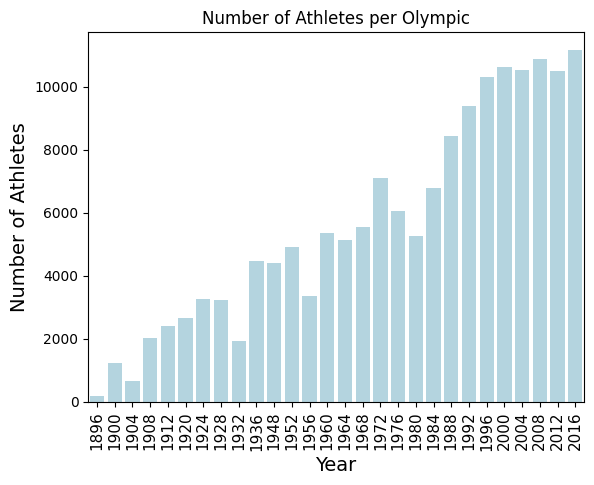

In [11]:
# Lets see the number of athletes per olympic 
sns.countplot(data=df_athletes, x='Year', color='lightblue')
plt.xticks(rotation=90, fontsize=11) 
plt.title('Number of Athletes per Olympic')
plt.ylabel('Number of Athletes', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.savefig(path + 'output/Number_of_Athletes_per_Olympic.png', bbox_inches='tight')
plt.show()

We can see that the number of participents is growing until around 1992, we will have to consider that.

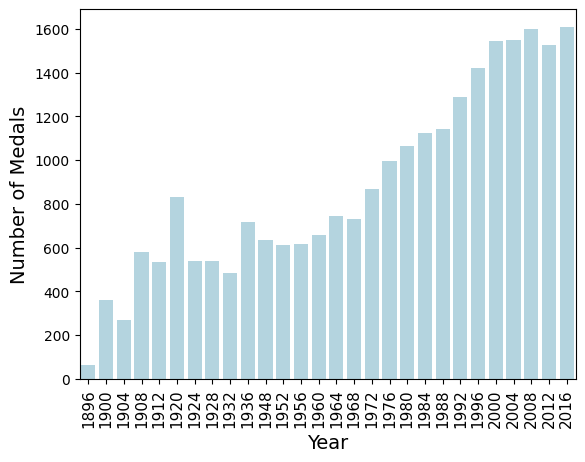

In [12]:
# lets see how many medals were given in each olympics
num_of_medals = df_athletes.groupby('Year')['Medal'].count().to_frame()

# lets plot it
sns.barplot(data=num_of_medals, x=num_of_medals.index, y='Medal', color='lightblue')
plt.xticks(rotation=90, fontsize=11)
plt.ylabel('Number of Medals', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.savefig(path + 'Number_of_Medals_per_Olympic.png', bbox_inches='tight')
plt.show()


#lets make this df as a dictionary
num_of_medals_dict = num_of_medals.to_dict()['Medal']

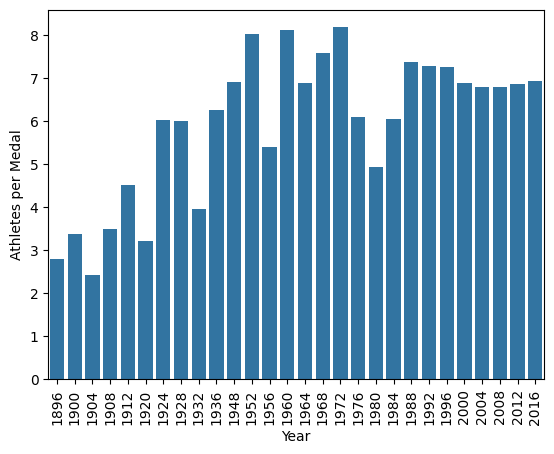

In [13]:
# lets see how many athletes are there for a medal
num_of_medals['Athletes'] = df_athletes.groupby('Year')['Name'].count().to_frame()
num_of_medals['athletes_per_medal'] = num_of_medals['Athletes'] / num_of_medals['Medal']
num_of_medals

# lets plot it
sns.barplot(data=num_of_medals, x=num_of_medals.index, y='athletes_per_medal')
plt.xlabel('Year')
plt.ylabel('Athletes per Medal')
plt.xticks(rotation=90);

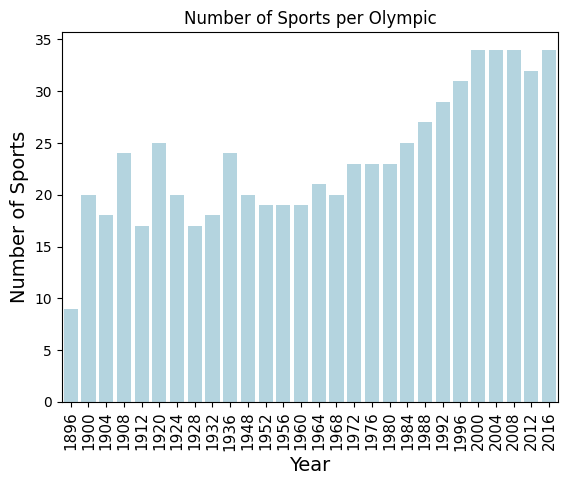

In [14]:
# lets see how many sports were in each olympics
num_of_sports = df_athletes.groupby('Year')['Sport'].nunique().to_frame()

sns.barplot(data=num_of_sports, x=num_of_sports.index, y='Sport', color='lightblue')
plt.xticks(rotation=90, fontsize=11)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Sports', fontsize=14)
plt.title('Number of Sports per Olympic')
plt.savefig(path + 'Number_of_Sports_per_Olympic.png', bbox_inches='tight')
plt.show()


It's interesting to see that the first olympic had had only 9 sports, while the next one, in 1900 had way more (20).

In [15]:
# and just for fun, lets see which sports were in 1912 and are not in 2016
sports_2016 = df_athletes[df_athletes['Year'] == 2016]['Sport'].unique()
sports_1912 = df_athletes[df_athletes['Year'] == 1912]['Sport'].unique()

sports_1912_not_in_2016 = [sport for sport in sports_1912 if sport not in sports_2016]

sports_1912_not_in_2016

['Art Competitions', 'Tug-Of-War']

That's cool, in 1912 there was 'Art Competition' ! 

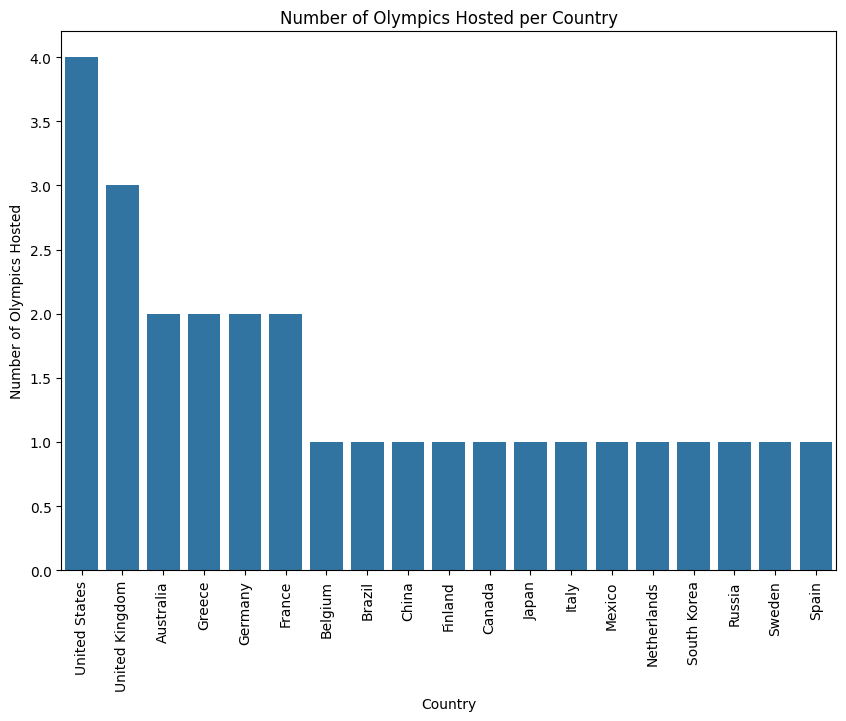

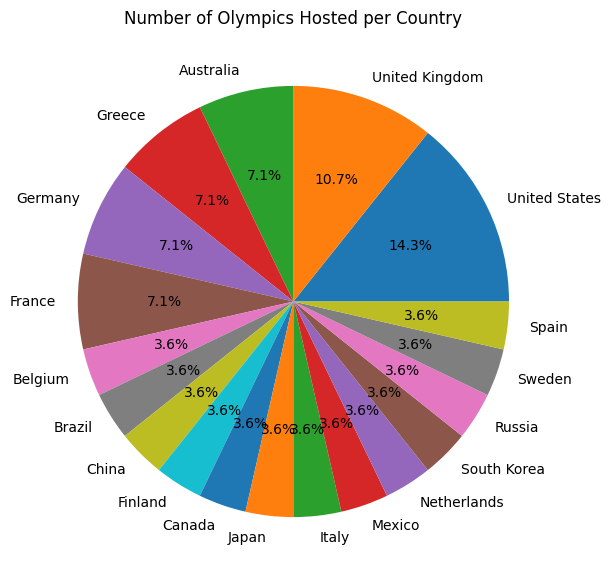

In [16]:
# lets see which country hosted the most games and how many
df_host_countries = df_athletes.groupby('Host_Country')['Year'].nunique().to_frame()
df_host_countries = df_host_countries.sort_values(by='Year', ascending=False)
df_host_countries

# lets create a beautiful plot
plt.figure(figsize=(10, 7))
sns.barplot(data=df_host_countries, x=df_host_countries.index, y='Year')
plt.title('Number of Olympics Hosted per Country')
plt.xlabel('Country')
plt.ylabel('Number of Olympics Hosted')

plt.xticks(rotation=90);
#lets make  a pie chart for the same data with count not percentages
plt.figure(figsize=(10, 7))
plt.pie(df_host_countries['Year'], labels=df_host_countries.index, autopct='%1.1f%%')
plt.title('Number of Olympics Hosted per Country')
plt.savefig(path + 'Number_of_Olympics_Hosted_per_Country.png', bbox_inches='tight')
plt.show()

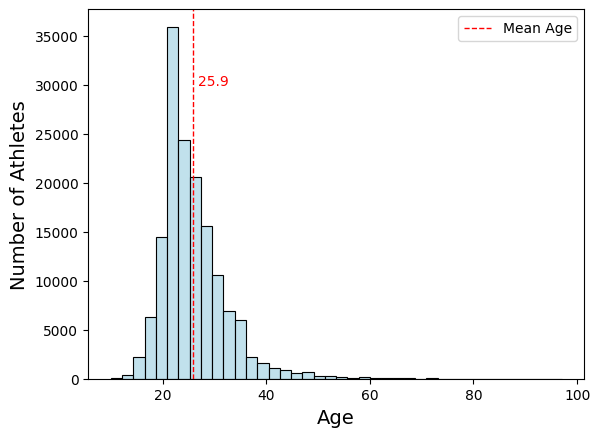

In [17]:
# lastly, lets see what is the age distribution of the athletes
sns.histplot(data=df_athletes, x='Age', bins=40, color='lightblue')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Athletes', fontsize=14)
plt.axvline(df_athletes['Age'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(df_athletes['Age'].mean() + 1, 30000, df_athletes['Age'].mean().round(1), color='red')
plt.legend(['Mean Age'])
plt.savefig(f'{path}output/Age_Distribution_of_Athletes.png', bbox_inches='tight')
plt.show()


ohh we have a weird value! Let's see what happend here

In [18]:
# lets find out what is the minumum and maximum age of the athletes
min_age = df_athletes['Age'].min()
max_age = df_athletes['Age'].max()

print(f'The minimum age of the athletes is: {min_age}')
print(f'The maximum age of the athletes is: {max_age}')
print(f'Number of athletes with no age data: {df_athletes[df_athletes["Age"].isna()].shape[0]}')

The minimum age of the athletes is: 10.0
The maximum age of the athletes is: 97.0
Number of athletes with no age data: 6065


Something is not right here, let's look deeper

In [19]:
# let's find the athletes who's age is the minimum
df_athletes[df_athletes['Age'] == min_age]


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,Host_City,Sport,Event,Medal,region,notes,Host_Country
142882,71691,Dimitrios Loundras,M,10.0,NaN,NaN,Ethnikos Gymnastikos Syllogos,GRE,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Bronze,Greece,NaN,Greece


When we searched online, we learned that Dimitrios Loundras was a Greek gymnast who competed at the 1896 Summer Olympics in Athens.  
He and his team won bronze medal.  
Even today, he is the youngest medalist and compatitor in Olympic history!  

Also, it look's like there are 6065 athletes with missing age data.

In [20]:
# let's find the athletes who's age is the maximum
df_athletes[df_athletes['Age'] == max_age]



,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,Host_City,Sport,Event,Medal,region,notes,Host_Country
257054,128719,John Quincy Adams Ward,M,97.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",NaN,United States,NaN,Netherlands


In [21]:
# let's find the athletes who's age is the maximum - 1
df_athletes[df_athletes['Age'] == max_age-1]



,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,Host_City,Sport,Event,Medal,region,notes,Host_Country
98118,49663,Winslow Homer,M,96.0,NaN,NaN,United States,USA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN,United States,NaN,United States


Now here's something cool, this guy John Quincy Adams Ward, actually died in 1910, aged 79!  
The reason his name is in the 1928 olympics, is because his scupltures took part in the art competition in 1928's olympic.  
This phenomena is the same with Winslow Homer, who died in 1910 at age 74, and his art was part of the 1932's olympic. 

<Figure size 1000x800 with 0 Axes>

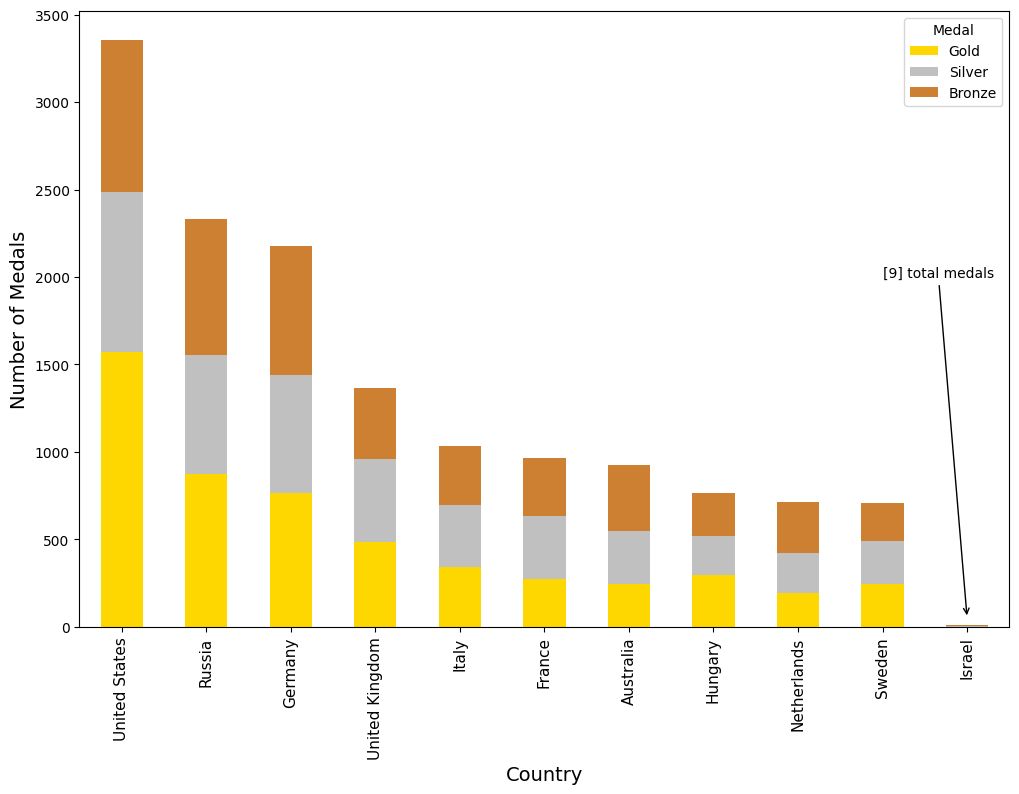

In [22]:
# lets group the data by Country and Medal, and count the number of medals for each country and medal type 
medal_counts_group = df_athletes.groupby(['region', 'Medal']).size().unstack(fill_value=0)
medal_counts_group['Total'] = medal_counts_group.sum(axis=1)
# and filter to include only top 10 countries with the most medals
medal_counts = medal_counts_group.nlargest(10, 'Total')

# lets add ISR to the medal_counts df
medal_counts.loc['Israel'] = medal_counts_group.loc['Israel']
#lets set them in the right order
medal_counts = medal_counts.sort_values(by='Total', ascending=False)
# now we will plot the data with a stacked bar chart and customizing the plot so every medal have the medal color
# and define the colors for each medal
colors = ['gold', 'silver', '#cd7f32']

# plotting the data
plt.figure(figsize=(10, 8))
#lets fix the order of the medals
medal_counts = medal_counts[['Gold', 'Silver', 'Bronze']]
medal_counts.plot(kind='bar', stacked=True, color=colors, figsize=(12, 8))

# let's see how many medals Israel won in total
total_medals = medal_counts_group.loc['Israel'].to_frame()

# and adding titles and labels
# plt.title('Distribution of Medals by Country')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Medals', fontsize=14)
plt.legend(title='Medal')
plt.xticks(rotation=90, fontsize=11)
plt.annotate(f'{total_medals.iloc[3].values} total medals', xy=(10, 50), xytext=(9, 2000),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.savefig(f'{path}output/Distribution_of_Medals_by_Country.png', bbox_inches='tight')
plt.show()

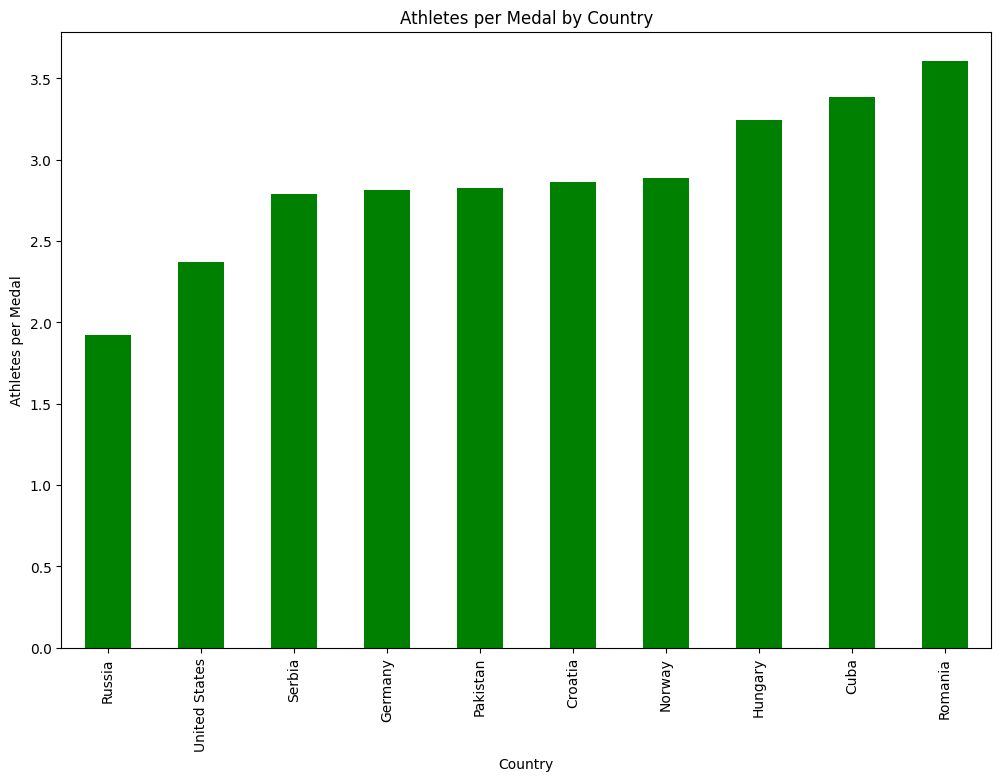

The number of medals Russia won is: 2331.0
The number of athletes Russia had is: 4478.0


In [23]:
# and now well divide by the number of athletes to get the medals per athlete
medal_counts_group['Total Athletes'] = df_athletes.groupby('region')['Name'].nunique()
medal_counts_group['Athletes per Medal'] = medal_counts_group['Total Athletes'] / medal_counts_group['Total']
medal_counts_group['Athletes per Medal'] = medal_counts_group['Athletes per Medal'].sort_values(ascending=False)

# let's take only the top 10 countries and Israel
medal_counts_group = medal_counts_group.nsmallest(10, 'Athletes per Medal')


# and plot the 10 countries with the most medals per athlete
medal_counts_group['Athletes per Medal'].plot(kind='bar', figsize=(12, 8), color='Green')
plt.title('Athletes per Medal by Country')
plt.xlabel('Country')
plt.ylabel('Athletes per Medal')
plt.xticks(rotation=90)
plt.show()

# just to make sure we are correct, lets see how many medals Russia won and how many athletes they had
print(f'The number of medals Russia won is: {medal_counts_group.loc["Russia"]["Total"]}')
print(f'The number of athletes Russia had is: {medal_counts_group.loc["Russia"]["Total Athletes"]}')



Russia won :(

## Research Question Analysis

The question we want to focus on is:
Does the fact that a country host the Olympic, can contribute to it's success?

In [24]:
# create an empty dataframe
df_athletes_host_countries = pd.DataFrame()

df_athletes_only_hosts = df_athletes_team_merging.copy()

# we'll include only the countries that hosted the olympics
df_athletes_only_hosts = df_athletes_only_hosts[df_athletes_only_hosts['region'].isin(df_host_countries.index)]

# df_athletes_only_hosts # ---  this df is the full df_athletes_team_merging but only for the host countries

In [25]:
# Here we made master_df to be the final df that we will use for the rest of the project, this turned out to be the easiest way to do it without getting lost in the code.
# create a df with the number of medals each country won every year
df_medal_counts_for_host_countries = df_athletes_only_hosts.groupby(['region', 'Year', 'Medal']).size().unstack(fill_value=0)
df_medal_counts_for_host_countries['Total Medals'] = df_medal_counts_for_host_countries.sum(axis=1) # creating a total column
df_medal_counts_for_host_countries = df_medal_counts_for_host_countries.reset_index()

# let's use df_athletes_team_merging to create a df with the year and the host country
df_year_host = df_athletes_team_merging[['Year', 'Host_Country']].drop_duplicates()
# let's merge the two df's
df_medal_counts_for_host_countries = df_medal_counts_for_host_countries.merge(df_year_host, on='Year', how='left')

# lastly, we'll add a column with the number of athletes each country had in the olympics
temp = df_athletes.groupby(['region', 'Year'])['Name'].count().to_frame().reset_index()
# renaming the 'Name' column to 'Country Athletes'
temp.rename(columns={'Name': 'Country Athletes'}, inplace=True)
temp[temp['region'] == 'United States']
# merging the two df's
df_medal_counts_for_host_countries = df_medal_counts_for_host_countries.merge(temp, on=['region', 'Year'], how='left')
# creating a new df called 'df_number_of_athletes_each_year' with the number of athletes that participated in the olympics every year
df_number_of_athletes_each_year = df_athletes.groupby('Year')['Name'].count().to_frame().reset_index()
df_number_of_athletes_each_year.rename(columns={'Name': 'Total Athletes'}, inplace=True)
# merging the two df's
df_medal_counts_for_host_countries = df_medal_counts_for_host_countries.merge(df_number_of_athletes_each_year, on='Year', how='left')
# creating a new column called 'Athletes Percentage' which is the number of athletes from the country divided by the total number of athletes
df_medal_counts_for_host_countries['Athletes Percentage'] = (df_medal_counts_for_host_countries['Country Athletes'] / df_medal_counts_for_host_countries['Total Athletes'])*100
# creating a new column called 'Total Medals Percentage' which is the number of Medals won by the country each year divided by the total number of Medals won by all countries in the same year using num_of_medals_dict
df_medal_counts_for_host_countries['Total Medals Percentage'] = df_medal_counts_for_host_countries.apply(
    lambda row: (row['Total Medals'] / num_of_medals_dict.get(row['Year'], 1)) * 100, axis=1
)
# finally, because we have so many dfs, we are going to use only one, named MASTER_DF!
master_df = df_medal_counts_for_host_countries.copy()

In [26]:
#lets see United States data
master_df[master_df['region'] == 'United States']

,region,Year,Bronze,Gold,Silver,Total Medals,Host_Country,Country Athletes,Total Athletes,Athletes Percentage,Total Medals Percentage
398,United States,1896,1,4,4,9,Greece,14,176,7.954545,14.285714
399,United States,1900,7,9,8,24,France,75,1220,6.147541,6.629834
400,United States,1904,35,35,42,112,United States,524,650,80.615385,41.947566
401,United States,1908,7,12,9,28,United Kingdom,122,2024,6.027668,4.819277
402,United States,1912,12,10,10,32,Sweden,174,2409,7.222914,5.992509
403,United States,1920,22,23,20,65,Belgium,288,2675,10.766355,7.793765
404,United States,1924,21,35,23,79,France,299,3256,9.183047,14.602588
405,United States,1928,12,19,16,47,Netherlands,280,3246,8.626001,8.703704
406,United States,1932,27,38,30,95,United States,474,1922,24.661811,19.587629
407,United States,1936,11,20,19,50,Germany,359,4482,8.009817,6.983240


In [27]:
#Here we created a class that will help us to analyze the data of a specific country
# we used the classes to make the code more readable and easier to understand, and also to make it easier to create the graphs and csv files.
# classes are a topic in python that we did not learn in any python course in our studies, and we wanted to use them in this project for learning purposes.
class HostCountry:
    def __init__(self, country):
        self.country = country
        self.df_country =  master_df[master_df['region'] == country] # getting only the specific country data
        self.df_country_when_hosted = self.df_country[self.df_country['Host_Country'] == country] # getting only the data of the country when it hosted the olympics
        self.df_country_not_hosted = self.df_country[self.df_country['Host_Country'] != country] # getting only the data of the country when it did not host the olympics
        self.avg_per_not_hosted = self.df_country_not_hosted['Total Medals Percentage'].mean().round(2) # getting the average percentage of medals the country won when it did not host the olympics
        self.avg_per_hosted = self.df_country_when_hosted['Total Medals Percentage'].mean().round(2) # getting the average percentage of medals the country won when it hosted the olympics


    def create_host_medals_graph(self, legend=True):
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.barplot(data=self.df_country, x='Year', y='Total Medals Percentage', color="#FFD700")
        plt.title(f'Percantage of Medals {self.country} Won in Each Olympic')
        plt.xticks(ticks=range(0, len(self.df_country)) , labels=self.df_country['Host_Country'], fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Host Country', fontsize=15)
        plt.ylabel('Percantage of Medals', fontsize=15)
        plt.xticks(rotation=90)

        for i in range(len(self.df_country)):
            if self.df_country.iloc[i]['Host_Country'] == self.country:
                plt.bar(i, self.df_country.iloc[i]['Total Medals Percentage'], color='red')
        didnt_host_avg = self.df_country_not_hosted['Total Medals Percentage'].mean().round(2)
        plt.axhline(y=didnt_host_avg, color='black', linestyle='--', label=f'Average Medals Percantage when {self.country} did not host')
        plt.text(28, didnt_host_avg+1, didnt_host_avg, fontsize=12)
        if legend:
            plt.legend()
        else: 
            plt.legend().set_visible(False)
        plt.savefig(f'{path}output/{self.country}_medals.png', bbox_inches='tight')
        plt.show()

    def create_host_athletes_percentage_graph(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.barplot(data=self.df_country, x='Year', y='Athletes Percentage', hue='Athletes Percentage')
        plt.title(f'Portion of Athletes {self.country} had in Each Olympic')
        plt.xticks(ticks=range(0, len(self.df_country)) , labels=self.df_country['Host_Country'], fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Host Country', fontsize=15)
        plt.ylabel('Athletes Percentage (%)', fontsize=15)
        plt.xticks(rotation=90)
        for i in range(len(self.df_country)):
            if self.df_country.iloc[i]['Host_Country'] == self.country:
                plt.bar(i, self.df_country.iloc[i]['Athletes Percentage'], color='red')
        plt.savefig(f'{path}output/{self.country}_athletes_percenttage.png', bbox_inches='tight')
        plt.show()

    def create_csv(self):
        self.df_for_output = self.df_country.copy()
        self.df_for_output['Athletes Percentage'] = self.df_for_output['Athletes Percentage'].round(2)
        self.df_for_output = self.df_for_output[['Year', 'Host_Country', 'Total Medals', 'Country Athletes','Total Athletes','Athletes Percentage']]
        self.df_for_output['average percentage of medals when not hosted'] = self.avg_per_not_hosted
        self.df_for_output['average percentage of medals when hosted'] = self.avg_per_hosted
        self.df_for_output.to_csv(f'{path}output/{self.country}_data.csv', index=False)
        
    def calculate_distance(self):
        self.df_country_when_hosted = self.df_country_when_hosted.copy()
        self.df_country_when_hosted.loc[:, 'Distance'] = self.df_country_when_hosted['Total Medals'].mean() - self.df_country_not_hosted['Total Medals'].mean()
        return self.df_country_when_hosted
    
    def show_graph(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.barplot(data=self.df_country, x='Year', y='Total Medals', hue='Total Medals')
        plt.title(f'Number of Medals {self.country} Won in Each Olympic')
        plt.xticks(ticks=range(0, len(self.df_country)) , labels=self.df_country['Host_Country'])
        plt.xlabel('Host Country')
        plt.ylabel('Number of Medals')
        plt.xticks(rotation=90)
        for i in range(len(self.df_country)):
            if self.df_country.iloc[i]['Host_Country'] == self.country:
                plt.bar(i, self.df_country.iloc[i]['Total Medals'], color='red')
        
        plt.show()       


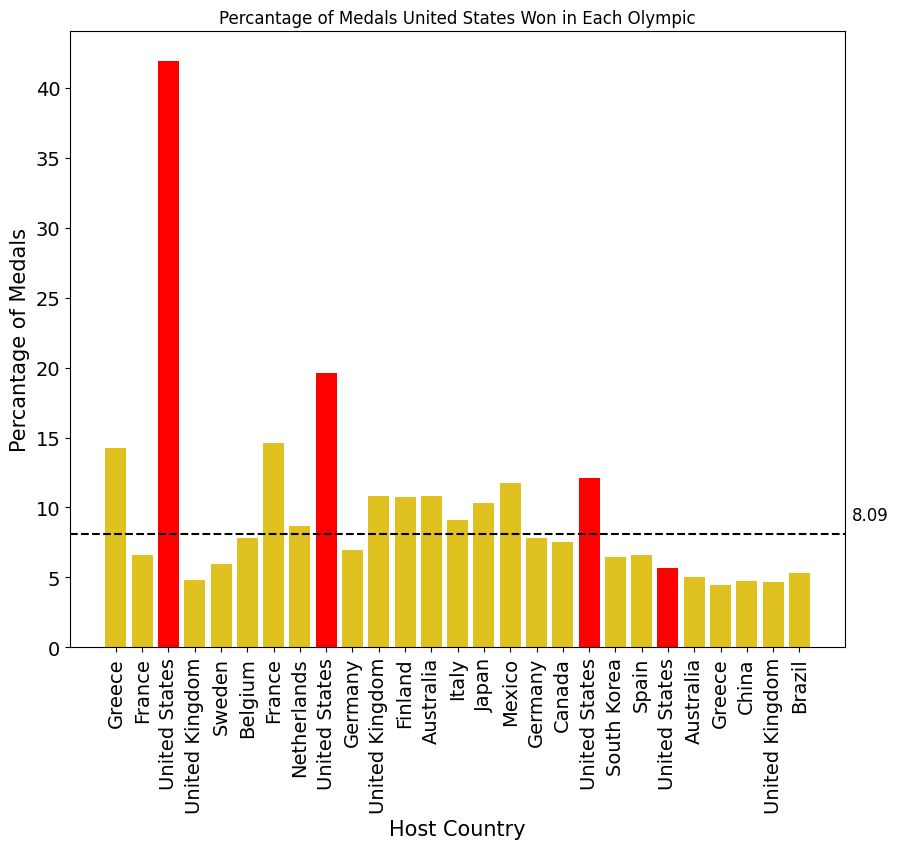

In [28]:
# creating a class instance for the United States
us = HostCountry('United States')
us.create_host_medals_graph(legend=False)
us.create_csv()

In [29]:
# Lets see the number of athletes per olympic 
num_of_athletes_per_olympic = df_athletes.groupby('Year')['Name'].nunique().reset_index()
num_of_athletes_per_olympic.rename(columns={'Name': 'num_of_athletes'}, inplace=True)

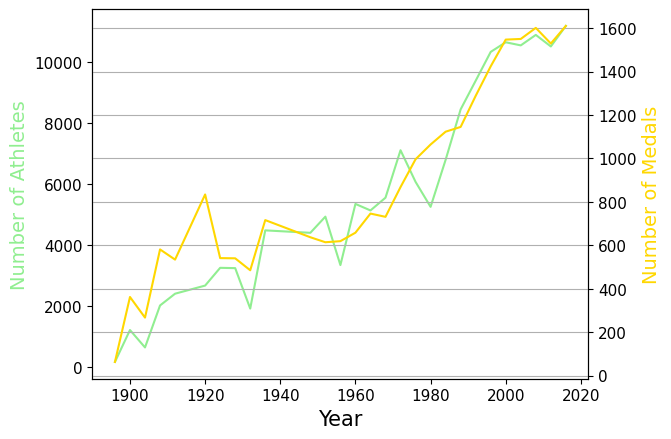

In [30]:
#lets make a scatter plot of both the number of athletes and the number of medals in the same plot with 2 different y axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(num_of_athletes_per_olympic['Year'], num_of_athletes_per_olympic['num_of_athletes'], '#90EE90')
ax2.plot(num_of_medals.index, num_of_medals['Medal'], '#FFD700')
ax1.set_xlabel('Year', fontsize=15)
ax1.set_ylabel('Number of Athletes', color='#90EE90',fontsize=14) 
#               path_effects=[path_effects.withStroke(linewidth=1, foreground='black')])
ax2.set_ylabel('Number of Medals', color='#FFD700',fontsize=14)
#               path_effects=[path_effects.withStroke(linewidth=1, foreground='black')])
# plt.title('Number of Athletes and Medals per Olympic')
plt.savefig(f'{path}output/Number_of_Athletes_and_Medals_per_Olympic.png')
#lets make ticks font size 11
ax1.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='both', which='major', labelsize=11)
plt.grid()
plt.show()


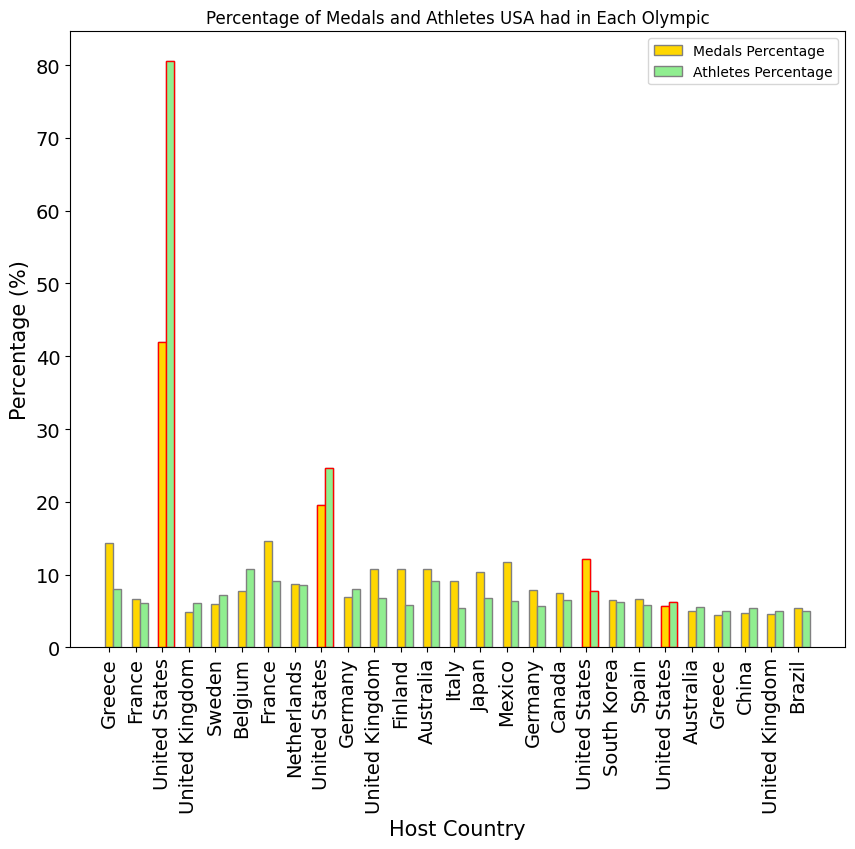

In [31]:
# lets make a combine barplot for percentage of medals usa won and athletes competed in each olympic
# and see the plots side by side
fig, ax = plt.subplots(figsize=(10, 8))
barWidth = 0.3
r1 = np.arange(len(us.df_country))
r2 = [x + barWidth for x in r1]
plt.bar(r1, us.df_country['Total Medals Percentage'], color='#FFD700', width=barWidth, edgecolor='grey', label='Medals Percentage')
plt.bar(r2, us.df_country['Athletes Percentage'], color='#90EE90', width=barWidth, edgecolor='grey', label='Athletes Percentage')
#lets change edge color for years that usa hosted to red #FFD700 #90EE90
for i in range(len(us.df_country)):
    if us.df_country.iloc[i]['Host_Country'] == 'United States':
        plt.bar(i, us.df_country.iloc[i]['Total Medals Percentage'], color='#FFD700', width=barWidth, edgecolor='red')
        plt.bar(i+barWidth, us.df_country.iloc[i]['Athletes Percentage'], color='#90EE90', width=barWidth, edgecolor='red')    
#lets add labels and titles
plt.xticks(ticks=range(0, len(us.df_country)) , labels=us.df_country['Host_Country'], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Host Country', fontsize=15)
plt.ylabel('Percentage (%)', fontsize=15)
plt.xticks(rotation=90)
plt.legend()
plt.title('Percentage of Medals and Athletes USA had in Each Olympic')
plt.savefig(f'{path}output/USA_medals_athletes.png', bbox_inches='tight')
plt.show()


In [32]:
#Here we created dfs for the boxplots
boxplot_us_medals_df = pd.DataFrame(columns=['year', 'medals percentage', 'hosted or not'])
boxplot_us_medals_df['year'] = us.df_country['Year']
boxplot_us_medals_df['medals percentage'] = us.df_country['Total Medals Percentage']
boxplot_us_medals_df['hosted or not'] = us.df_country['Host_Country'].apply(lambda x: 'hosted' if x == 'United States' else 'not hosted')

boxplot_us_athletes_df = pd.DataFrame(columns=['year', 'athletes percentage', 'hosted or not'])
boxplot_us_athletes_df['year'] = us.df_country['Year']
boxplot_us_athletes_df['athletes percentage'] = us.df_country['Athletes Percentage']
boxplot_us_athletes_df['hosted or not'] = us.df_country['Host_Country'].apply(lambda x: 'hosted' if x == 'United States' else 'not hosted')

boxplos_us_ratio_df = pd.DataFrame(columns=['year','athletes percentage and medals percentage ratio', 'hosted or not'])
boxplos_us_ratio_df['year'] = us.df_country['Year']
boxplos_us_ratio_df['athletes percentage and medals percentage ratio'] = us.df_country['Total Medals Percentage'] / us.df_country['Athletes Percentage']
boxplos_us_ratio_df['hosted or not'] = boxplot_us_athletes_df['hosted or not']

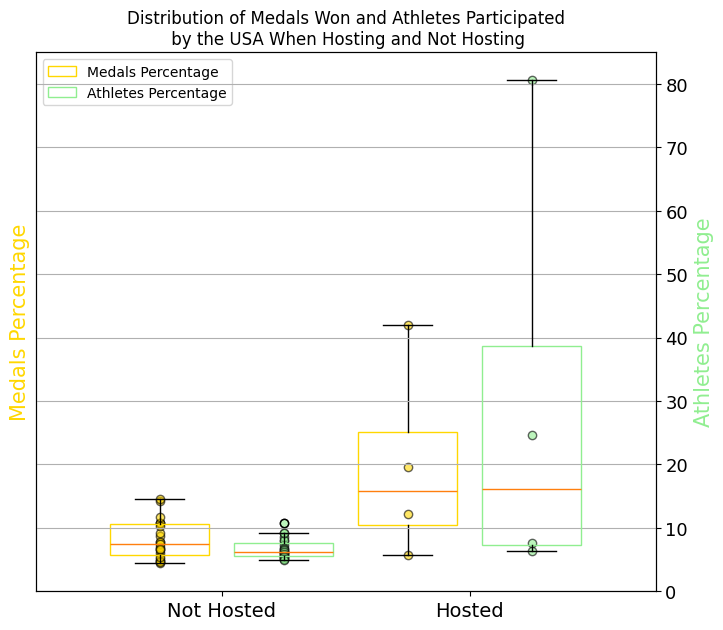

In [33]:
categories = boxplot_us_medals_df['hosted or not'].unique()
medals_data = [boxplot_us_medals_df[boxplot_us_medals_df['hosted or not'] == cat]['medals percentage'] for cat in categories]
athletes_data = [boxplot_us_athletes_df[boxplot_us_athletes_df['hosted or not'] == cat]['athletes percentage'] for cat in categories]

# setting the positions for the boxplots
positions_medals = np.arange(len(categories)) * 1 - 0.25  # Closer positions
positions_athletes = np.arange(len(categories)) * 1 + 0.25  # Closer positions

fig, ax1 = plt.subplots(figsize=(8, 7))

# plotting the first boxplot.
box1 = ax1.boxplot(medals_data, positions=positions_medals, widths=0.4,  # Narrower width
                    patch_artist=True, boxprops=dict(facecolor='none', edgecolor='#FFD700'))
ax1.set_ylabel('Medals Percentage', color='#FFD700', fontsize=15)

for i, data in enumerate(medals_data):
    ax1.scatter([positions_medals[i]] * len(data), data, color='#FFD700', alpha=0.6, edgecolor='black')

# creating a second y-axis for the athletes boxplot
ax2 = ax1.twinx()

# plotting the second boxplot.
box2 = ax2.boxplot(athletes_data, positions=positions_athletes, widths=0.4,  # Narrower width
                    patch_artist=True, boxprops=dict(facecolor='none', edgecolor='#90EE90'))
ax2.set_ylabel('Athletes Percentage', color='#90EE90', fontsize=15)

# adding individual data points for athletes
for i, data in enumerate(athletes_data):
    ax2.scatter([positions_athletes[i]] * len(data), data, color='#90EE90', alpha=0.6, edgecolor='black')

# Adjust x-axis ticks and labels
ax1.set_xticks(np.arange(len(categories))) 
ax1.set_xticklabels(categories)
plt.yticks(fontsize=13)
ax1.set_xticklabels(categories, fontsize=14)

plt.title('Distribution of Medals Won and Athletes Participated\n by the USA When Hosting and Not Hosting')
ax1.set_ylim(0, 85)
ax2.set_ylim(0, 85)
# lets add a legend and delete y labels and y ticks
ax1.legend([box1["boxes"][0], box2["boxes"][0]], ['Medals Percentage', 'Athletes Percentage'], loc='upper left')
ax1.set_yticks([])
# lets add capital letters to the x axis ticks
ax1.set_xticklabels(['Not Hosted', 'Hosted'])
# lets add a grid
plt.grid(axis='y')
# saving the plot and showing it
plt.savefig(f'{path}output/USA_medals_athletes_boxplot_with_points_closer.png', bbox_inches='tight')
plt.show()


/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_6906/1694397659.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplos_us_ratio_df, x='hosted or not', y='athletes percentage and medals percentage ratio', palette='Set3')


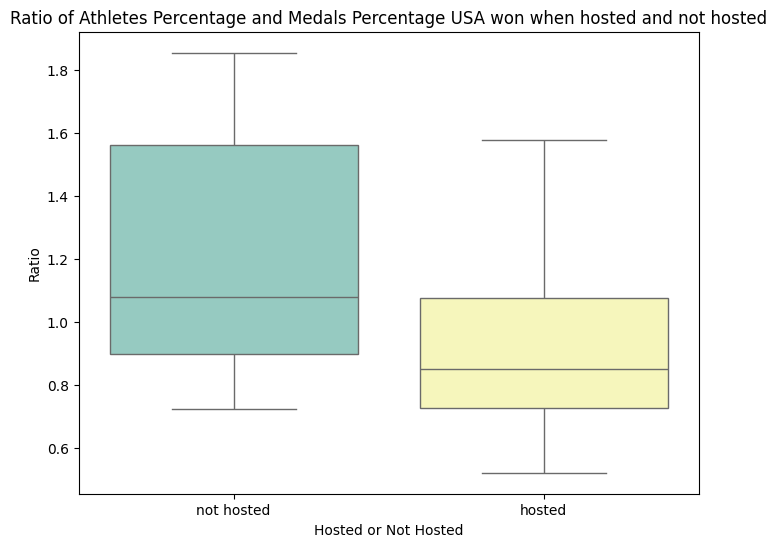

In [34]:
# lets plot the ratio of athletes percentage and medals percentage and the mean of the ratio when hosted and not hosted
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=boxplos_us_ratio_df, x='hosted or not', y='athletes percentage and medals percentage ratio', palette='Set3')
plt.title('Ratio of Athletes Percentage and Medals Percentage USA won when hosted and not hosted')
plt.ylabel('Ratio')
plt.xlabel('Hosted or Not Hosted')
plt.savefig(f'{path}output/USA_ratio.png', bbox_inches='tight')
plt.show()


In [35]:
# lets create a df with the distance between the mean of the non host countries and the host country
host_countries = df_host_countries.copy()
host_countries.rename(columns={'Year': 'Years hosted'}, inplace=True)
host_countries['Medals mean hosting'] = 0
host_countries['Medals mean'] = 0
host_countries['Medals Won Percentage When Hosted'] = 0
host_countries['Medals Won Percentage When Not Hosted'] = 0

# host_countries['distance_sum'] = 0
host_countries['distance_mean'] = 0
# host_countries['distance_sum'] = host_countries['distance_sum'].astype(float)
host_countries['distance_mean'] = host_countries['distance_mean'].astype(float)
host_countries['Medals mean hosting'] = host_countries['Medals mean hosting'].astype(float)
host_countries['Medals mean'] = host_countries['Medals mean'].astype(float)
host_countries['Medals Won Percentage When Hosted'] = host_countries['Medals Won Percentage When Hosted'].astype(float)
host_countries['Medals Won Percentage When Not Hosted'] = host_countries['Medals Won Percentage When Not Hosted'].astype(float)

for country in host_countries.index:
    host_country = HostCountry(country)
    host_countries.loc[country,'Medals mean hosting'] = host_country.df_country_when_hosted['Total Medals'].mean().round(2)
    # host_countries.loc[country,'Medals mean'] = host_country.df_country['Total Medals'].mean().round(2)
    host_countries.loc[country,'Medals mean'] = host_country.df_country_not_hosted['Total Medals'].mean().round(2)
    host_countries.loc[country, 'distance_sum'] = host_country.calculate_distance()['Distance'].sum().round(2)
    host_countries.loc[country, 'Medals Won Percentage When Hosted'] = host_country.avg_per_hosted.mean().round(2)
    host_countries.loc[country, 'Medals Won Percentage When Not Hosted'] = host_country.avg_per_not_hosted.mean().round(2)
    host_countries.loc[country, 'distance_mean'] = round(host_country.calculate_distance()['Distance'].mean(), 2)

host_countries['percentage delta'] = host_countries['Medals Won Percentage When Hosted'] - host_countries['Medals Won Percentage When Not Hosted']


host_countries = host_countries.sort_values(by='distance_mean', ascending=False)
host_countries.to_csv(f'{path}data/host_countries.csv')
host_countries

host_countries_for_word = host_countries.copy()
# lets discard the columns that we dont need
host_countries_for_word = host_countries_for_word.drop(columns=['Medals mean hosting', 'Medals mean','distance_mean', 'distance_sum'])
# lets rename the columns
host_countries_for_word.rename(columns={'percentage delta': 'Medals Percentage Delta'}, inplace=True)
# lets add athlets percentage mean when hosted and not hosted for each country
host_countries_for_word['Athletes Percentage Mean When Hosted'] = 0
host_countries_for_word['Athletes Percentage Mean When Not Hosted'] = 0
for country in host_countries_for_word.index:
    host_country = HostCountry(country)
    host_countries_for_word.loc[country, 'Athletes Percentage Mean When Hosted'] = host_country.df_country_when_hosted['Athletes Percentage'].mean().round(2)
    host_countries_for_word.loc[country, 'Athletes Percentage Mean When Not Hosted'] = host_country.df_country_not_hosted['Athletes Percentage'].mean().round(2)
# lets add the ratio of athletes percentage and medals percentage mean when hosted and not hosted for each country
host_countries_for_word['Athletes Percentage and Medals Percentage Ratio When Hosted'] = host_countries_for_word['Medals Won Percentage When Hosted'] / host_countries_for_word['Athletes Percentage Mean When Hosted']
host_countries_for_word['Athletes Percentage and Medals Percentage Ratio When Not Hosted'] = host_countries_for_word['Medals Won Percentage When Not Hosted'] / host_countries_for_word['Athletes Percentage Mean When Not Hosted']
# lets add dif between the ratio of athletes percentage and medals percentage mean when hosted and not hosted for each country and locate it in the right place
host_countries_for_word['Athletes Percentage and Medals Percentage Ratio Delta'] = host_countries_for_word['Athletes Percentage and Medals Percentage Ratio When Hosted'] - host_countries_for_word['Athletes Percentage and Medals Percentage Ratio When Not Hosted']
# lets add atheletes percentage mean delta for each country and locate it in the 7th place
host_countries_for_word['Athletes Percentage Mean Delta'] = host_countries_for_word['Athletes Percentage Mean When Hosted'] - host_countries_for_word['Athletes Percentage Mean When Not Hosted']
host_countries_for_word = host_countries_for_word[['Years hosted', 'Medals Won Percentage When Hosted', 'Medals Won Percentage When Not Hosted', 'Medals Percentage Delta', 'Athletes Percentage Mean When Hosted', 'Athletes Percentage Mean When Not Hosted', 'Athletes Percentage Mean Delta', 'Athletes Percentage and Medals Percentage Ratio When Hosted', 'Athletes Percentage and Medals Percentage Ratio When Not Hosted', 'Athletes Percentage and Medals Percentage Ratio Delta']]

# lets make all the numbers only 2 digits after the dot
host_countries_for_word = host_countries_for_word.round(3)
# lets save the data
host_countries_for_word.to_csv(f'{path}data/host_countries_for_word.csv')
host_countries_for_word

/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_6906/2886003203.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.31' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  host_countries_for_word.loc[country, 'Athletes Percentage Mean When Hosted'] = host_country.df_country_when_hosted['Athletes Percentage'].mean().round(2)
/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_6906/2886003203.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.94' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  host_countries_for_word.loc[country, 'Athletes Percentage Mean When Not Hosted'] = host_country.df_country_not_hosted['Athletes Percentage'].mean().round(2)


,Years hosted,Medals Won Percentage When Hosted,Medals Won Percentage When Not Hosted,Medals Percentage Delta,Athletes Percentage Mean When Hosted,Athletes Percentage Mean When Not Hosted,Athletes Percentage Mean Delta,Athletes Percentage and Medals Percentage Ratio When Hosted,Athletes Percentage and Medals Percentage Ratio When Not Hosted,Athletes Percentage and Medals Percentage Ratio Delta
Host_Country,,,,,,,,,,
Russia,1,14.57,6.51,8.06,9.31,4.94,4.37,1.565,1.318,0.247
Germany,2,10.60,4.45,6.15,9.89,5.96,3.93,1.072,0.747,0.325
United States,4,19.83,8.09,11.74,29.81,6.72,23.09,0.665,1.204,-0.539
United Kingdom,3,8.52,2.46,6.06,16.87,4.97,11.90,0.505,0.495,0.010
China,1,4.75,2.99,1.76,5.67,3.49,2.18,0.838,0.857,-0.019
France,2,11.20,2.19,9.01,35.50,4.46,31.04,0.315,0.491,-0.176
Belgium,1,3.48,0.57,2.91,12.56,2.03,10.53,0.277,0.281,-0.004
Australia,2,3.54,1.15,2.39,7.35,2.37,4.98,0.482,0.485,-0.004
Greece,2,22.71,0.24,22.47,31.00,0.98,30.02,0.733,0.245,0.488


### Permutation Tests

We experimented with multiple ways of calculating the p-value using permutation tests.  
We ended up using the last 2 because it was more relevant and informative to our case.

In [36]:
def permutation_tests_medals(country):
    # getting the percentage for the given country
    observed_percentages = host_countries_for_word.loc[country, 'Medals Percentage Delta']
    print(f'observed percentage: {observed_percentages}')
    
    # getting the percentages for all countries
    all_percentages = host_countries_for_word['Medals Percentage Delta'].values
    print(f'all percentages: {all_percentages}')
    
    # setting the random seed for reproducibility
    np.random.seed(0)
    
    # creating an empty array to store the permutation test statistics
    permutation_statistics = np.zeros(10000)
    
    # perform the permutation test
    for i in range(10000):
        # permute the percentages
        permuted_distances = np.random.permutation(all_percentages)
        
        # compute the statistic for the permutation
        # for each permutation, use the percentage of the position corresponding to the original country
        permuted_distance_sum = permuted_distances[host_countries.index.get_loc(country)]
        
        # storing the statistic
        permutation_statistics[i] = permuted_distance_sum
    
    # computing the p-value
    p_value = np.mean(np.abs(permutation_statistics - np.mean(all_percentages)) >= np.abs(observed_percentages - np.mean(all_percentages)))
    
    print(f'p-value: {p_value}')
    
    return p_value.round(3), observed_percentages.round(3)



In [37]:
for country in host_countries.index:
    print(f'Permutation test for {country}')
    permutation_tests_medals(country)
    print('-----------------------------------------')

    # creating the df for the permutation test
df_permutation_test = pd.DataFrame()
df_permutation_test['Country'] = host_countries.index
df_permutation_test['Observed Difference'] = 0
df_permutation_test['p-value'] = 0
df_permutation_test = df_permutation_test.set_index('Country')
for country in host_countries.index:
    df_permutation_test.loc[country, 'p-value'] = permutation_tests_medals(country)[0]
    df_permutation_test.loc[country, 'Observed Difference'] = permutation_tests_medals(country)[1]


df_permutation_test.to_csv(f'{path}data/permutation_test.csv')
df_permutation_test

Permutation test for Russia
observed percentage: 8.06
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.4267
-----------------------------------------
Permutation test for Germany
observed percentage: 6.15
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.8444
-----------------------------------------
Permutation test for United States
observed percentage: 11.74
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.1085
-----------------------------------------
Permutation test for United Kingdom
observed percentage: 6.06
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.9494
-----------------------------------------

/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_6906/2478024198.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_permutation_test.loc[country, 'p-value'] = permutation_tests_medals(country)[0]
/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_6906/2478024198.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_permutation_test.loc[country, 'Observed Difference'] = permutation_tests_medals(country)[1]


p-value: 0.4267
observed percentage: 6.15
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.8444
observed percentage: 6.15
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.8444
observed percentage: 11.74
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.1085
observed percentage: 11.74
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.1085
observed percentage: 6.06
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.02  1.57  2.67
  0.91  0.52  1.51  2.25  0.72  1.18 -0.44]
p-value: 0.9494
observed percentage: 6.06
all percentages: [ 8.06  6.15 11.74  6.06  1.76  9.01  2.91  2.39 22.47  4.0

,Observed Difference,p-value
Country,,
Russia,8.06,0.427
Germany,6.15,0.844
United States,11.74,0.108
United Kingdom,6.06,0.949
China,1.76,0.622
France,9.01,0.211
Belgium,2.91,0.893
Australia,2.39,0.736
Greece,22.47,0.051


In [38]:
def permutation_tests_ratio(country):
    # getting the percentage for the given country
    observed_percentages = host_countries_for_word.loc[country, 'Athletes Percentage and Medals Percentage Ratio Delta']
    print(f'observed percentage: {observed_percentages}')
    
    # getting the percentages for all countries
    all_percentages = host_countries_for_word['Athletes Percentage and Medals Percentage Ratio Delta'].values
    print(f'all percentages: {all_percentages}')
    
    # setting the random seed for reproducibility
    np.random.seed(0)
    
    # creating an empty array to store the permutation test statistics
    permutation_statistics = np.zeros(10000)
    
    # perform the permutation test
    for i in range(10000):
        # permute the percentages
        permuted_distances = np.random.permutation(all_percentages)
        
        # compute the statistic for the permutation
        # for each permutation, use the percentage of the position corresponding to the original country
        permuted_distance_sum = permuted_distances[host_countries.index.get_loc(country)]
        
        # Store the statistic
        permutation_statistics[i] = permuted_distance_sum
    
    # Compute the p-value
    # The p-value is the proportion of permuted statistics that are at least as extreme as the observed statistic
    p_value = np.mean(np.abs(permutation_statistics - np.mean(all_percentages)) >= np.abs(observed_percentages - np.mean(all_percentages)))
    
    print(f'p-value: {p_value}')
    
    return p_value.round(3), observed_percentages.round(3)



In [39]:
for country in host_countries.index:
    print(f'Permutation test for {country}')
    permutation_tests_ratio(country)
    print('--------------------------------------------------')

    # creating the df for the permutation test
df_permutation_test = pd.DataFrame()
df_permutation_test['Country'] = host_countries.index
df_permutation_test['Observed Difference'] = 0
df_permutation_test['p-value'] = 0
df_permutation_test = df_permutation_test.set_index('Country')
for country in host_countries.index:
    df_permutation_test.loc[country, 'p-value'] = permutation_tests_ratio(country)[0]
    df_permutation_test.loc[country, 'Observed Difference'] = permutation_tests_ratio(country)[1]


df_permutation_test.to_csv(f'{path}data/permutation_test.csv')
df_permutation_test



Permutation test for Russia
observed percentage: 0.247
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.3713
--------------------------------------------------
Permutation test for Germany
observed percentage: 0.325
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.2135
--------------------------------------------------
Permutation test for United States
observed percentage: -0.539
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.0538
--------------------------------------------------
Permutation test for United Kingdom
observed percentage: 0.01
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  

/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_6906/979803958.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.371' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_permutation_test.loc[country, 'p-value'] = permutation_tests_ratio(country)[0]
/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_6906/979803958.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_permutation_test.loc[country, 'Observed Difference'] = permutation_tests_ratio(country)[1]


p-value: 0.0538
observed percentage: 0.01
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.84
observed percentage: 0.01
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.84
observed percentage: -0.019
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.6811
observed percentage: -0.019
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.6811
observed percentage: -0.176
all percentages: [ 0.247  0.325 -0.539  0.01  -0.019 -0.176 -0.004 -0.004  0.488 -0.296
  0.01   0.354  0.088 -0.012 -0.159  0.032  0.008 -0.071 -0.251]
p-value: 0.4207
observe

,Observed Difference,p-value
Country,,
Russia,0.247,0.371
Germany,0.325,0.214
United States,-0.539,0.054
United Kingdom,0.010,0.840
China,-0.019,0.681
France,-0.176,0.421
Belgium,-0.004,1.000
Australia,-0.004,1.000
Greece,0.488,0.100


In [40]:
# computing the observed difference in medals percentage ---
observed_diff = host_countries_for_word["Medals Won Percentage When Hosted"].mean() - host_countries_for_word["Medals Won Percentage When Not Hosted"].mean()

# permutation test function
def permutation_test(host_countries_for_word, num_permutations=10000):
    # creating an empty list to store the permuted test statistics
    permuted_diffs = []
    
    # merging hosted and not hosted percentages
    combined = np.concatenate([host_countries_for_word["Medals Won Percentage When Hosted"].values, 
                                host_countries_for_word["Medals Won Percentage When Not Hosted"].values])
    
    # performing permutations
    for _ in range(num_permutations):
        # shuffling the combined data
        np.random.shuffle(combined)
        
        # splitting the shuffled data into two groups
        permuted_group1 = combined[:len(host_countries_for_word["Medals Won Percentage When Hosted"])]
        permuted_group2 = combined[len(host_countries_for_word["Medals Won Percentage When Hosted"]):]
        
        # computing the difference in means
        permuted_diff = permuted_group1.mean() - permuted_group2.mean()
        permuted_diffs.append(permuted_diff)
    
    # computing the p-value
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value

# running the permutation test with a larger number of permutations
observed_diff, p_value = permutation_test(host_countries_for_word, num_permutations=10000)  # Adjust this number if needed

print(f"Observed Difference in Medals Won Percentage: {observed_diff:.2f}")
print(f"P-Value: {p_value:.4f}")

# printing the conclutions
if p_value < 0.05:
    print("Reject the null hypothesis: There is evidence that hosting affects the percentage of medals won.")
else:
    print("Fail to reject the null hypothesis: There is no evidence that hosting affects the percentage of medals won.")


Observed Difference in Medals Won Percentage: 4.50
P-Value: 0.0028
Reject the null hypothesis: There is evidence that hosting affects the percentage of medals won.


In [41]:
# extracting the relevant columns ----
ratio_hosted = host_countries_for_word['Athletes Percentage and Medals Percentage Ratio When Hosted'].dropna()
ratio_not_hosted = host_countries_for_word['Athletes Percentage and Medals Percentage Ratio When Not Hosted'].dropna()

# calculating the observed difference in means
observed_diff = ratio_hosted.mean() - ratio_not_hosted.mean()

# a function to perform a permutation test
def permutation_test(ratio_hosted, ratio_not_hosted, n_permutations=10000):
    combined = np.concatenate([ratio_hosted, ratio_not_hosted])
    diff_means = []
    
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        new_hosted = combined[:len(ratio_hosted)]
        new_not_hosted = combined[len(ratio_hosted):]
        diff_means.append(new_hosted.mean() - new_not_hosted.mean())
    
    p_value = np.sum(np.abs(diff_means) >= np.abs(observed_diff)) / n_permutations
    return p_value

# performing the permutation test
p_value = permutation_test(ratio_hosted, ratio_not_hosted)

print(f'Observed Difference: {observed_diff}')
print(f'p-value: {p_value}')


Observed Difference: 0.0016842105263159546
p-value: 0.9864


In [42]:
# Extract the relevant data
hosted_data = host_countries_for_word['Athletes Percentage Mean When Hosted'].dropna()
not_hosted_data = host_countries_for_word['Athletes Percentage Mean When Not Hosted'].dropna()

# Calculate the observed difference in means
observed_diff = hosted_data.mean() - not_hosted_data.mean()

# Combine the data
combined_data = np.concatenate([hosted_data, not_hosted_data])

# Initialize the permutation test parameters
num_permutations = 10000
permutation_diffs = np.zeros(num_permutations)

# Perform the permutations
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data into two groups
    new_hosted = combined_data[:len(hosted_data)]
    new_not_hosted = combined_data[len(hosted_data):]
    
    # Calculate the difference in means for the permuted data
    permutation_diffs[i] = new_hosted.mean() - new_not_hosted.mean()

# Calculate the p-value
p_value = np.mean(np.abs(permutation_diffs) >= np.abs(observed_diff))

# Output the results
print(f'Observed difference: {observed_diff}')
print(f'p-value: {p_value}')


Observed difference: 8.732105263157894
p-value: 0.0


## Other

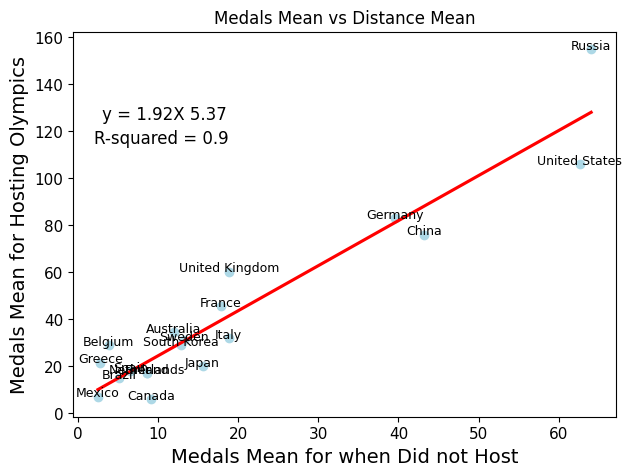

In [43]:
# let's create a scatter plot of the medals mean and the distance mean
plt.figure(figsize=(7, 5))
plt.scatter(host_countries['Medals mean'], host_countries['Medals mean hosting'], color='lightblue')
# adding the country names to the points
for i in range(len(host_countries)):
    plt.text(host_countries.iloc[i]['Medals mean'], host_countries.iloc[i]['Medals mean hosting'], host_countries.index[i], fontsize=9, color='black', ha='center')
# adding a regression line
sns.regplot(data=host_countries, x='Medals mean', y='Medals mean hosting', scatter=False, color='red', ci=False)

# calculating the coefficient and the intercept
m, b = np.polyfit(host_countries['Medals mean'], host_countries['Medals mean hosting'], 1)
plt.text(3, 125, f'y = {m.round(2)}X {b.round(2)}', fontsize=12)
r_squared = np.corrcoef(host_countries['Medals mean'], host_countries['Medals mean hosting'])[0, 1] ** 2
plt.text(2, 115, f'R-squared = {r_squared.round(2)}', fontsize=12,)
plt.xlabel('Medals Mean for when Did not Host', fontsize=14)
plt.ylabel('Medals Mean for Hosting Olympics', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Medals Mean vs Distance Mean')
plt.savefig('output/Medals_Mean_vs_Distance_Mean.png', bbox_inches='tight')
plt.show()


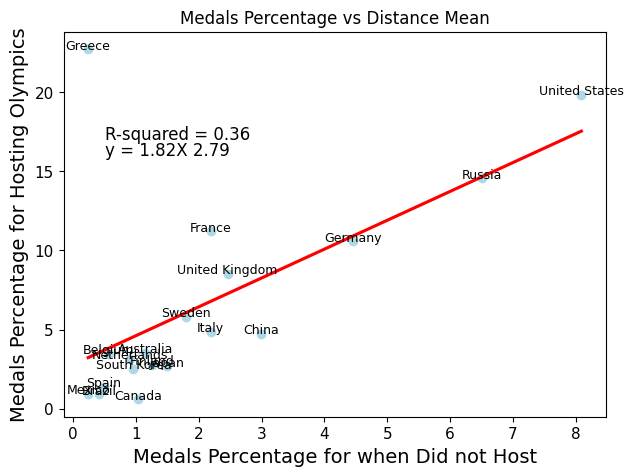

In [44]:
#lets do same as above but with the percentage of medals
plt.figure(figsize=(7, 5))
plt.scatter(host_countries['Medals Won Percentage When Not Hosted'], host_countries['Medals Won Percentage When Hosted'], color='lightblue')
# adding the country names to the points
for i in range(len(host_countries)):
    plt.text(host_countries.iloc[i]['Medals Won Percentage When Not Hosted'], host_countries.iloc[i]['Medals Won Percentage When Hosted'], host_countries.index[i], fontsize=9, color='black', ha='center')
# adding a regression line
sns.regplot(data=host_countries, x='Medals Won Percentage When Not Hosted', y='Medals Won Percentage When Hosted', scatter=False, color='red', ci=False)

# calculating the coefficient and the intercept
m, b = np.polyfit(host_countries['Medals Won Percentage When Not Hosted'], host_countries['Medals Won Percentage When Hosted'], 1)
plt.text(0.5, 16, f'y = {m.round(2)}X {b.round(2)}', fontsize=12)
r_squared = np.corrcoef(host_countries['Medals Won Percentage When Not Hosted'], host_countries['Medals Won Percentage When Hosted'])[0, 1] ** 2
plt.text(0.5, 17, f'R-squared = {r_squared.round(2)}', fontsize=12,)
plt.xlabel('Medals Percentage for when Did not Host', fontsize=14)
plt.ylabel('Medals Percentage for Hosting Olympics', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Medals Percentage vs Distance Mean')
plt.savefig(f'{path}output/Medals_Percentage_vs_Distance_Mean.png', bbox_inches='tight')
plt.show()


In examining the USA's performance, it is clear from Figure 6 that the USA won significantly more medals when it hosted the Olympics. A permutation test yielded a p-value of 0.0538, suggesting a notable, though not statistically significant difference in medal counts when hosting.
Figure 6 reveals a key factor, the number of USA athletes was much higer in the games they hosted. For example, in 1904, 80% of the athletes were from the USA. This pattern is less pronounced in later years, such as the 1984 Olympics, where despite a lower percentage of athletes (7.69%), the USA still won 136 medals. This anomaly can be attributed to the Soviet-led boycott, which reduced competition.
Future research could explore how the home advantage has evolved over time. One interesting study suggests that the home advantage benefits male athletes more than female athletes, providing a potential avenue for further investigation.


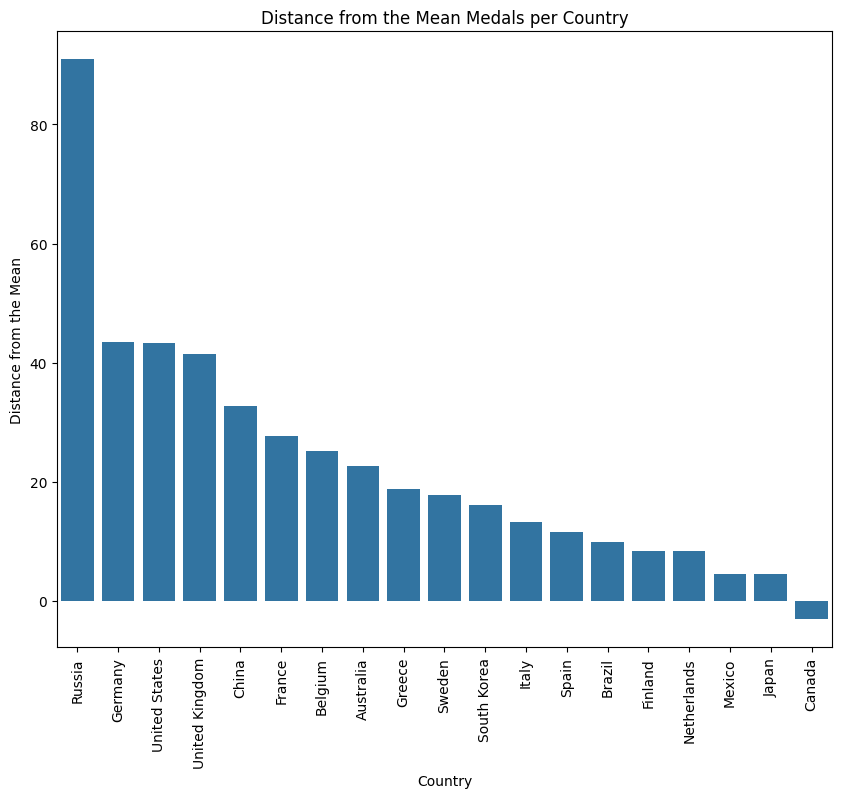

In [45]:
# let's plot the data
plt.figure(figsize=(10, 8))
sns.barplot(data=host_countries, x=host_countries.index, y='distance_mean')
plt.title('Distance from the Mean Medals per Country')
plt.xlabel('Country')
plt.ylabel('Distance from the Mean')
plt.xticks(rotation=90)
plt.show()



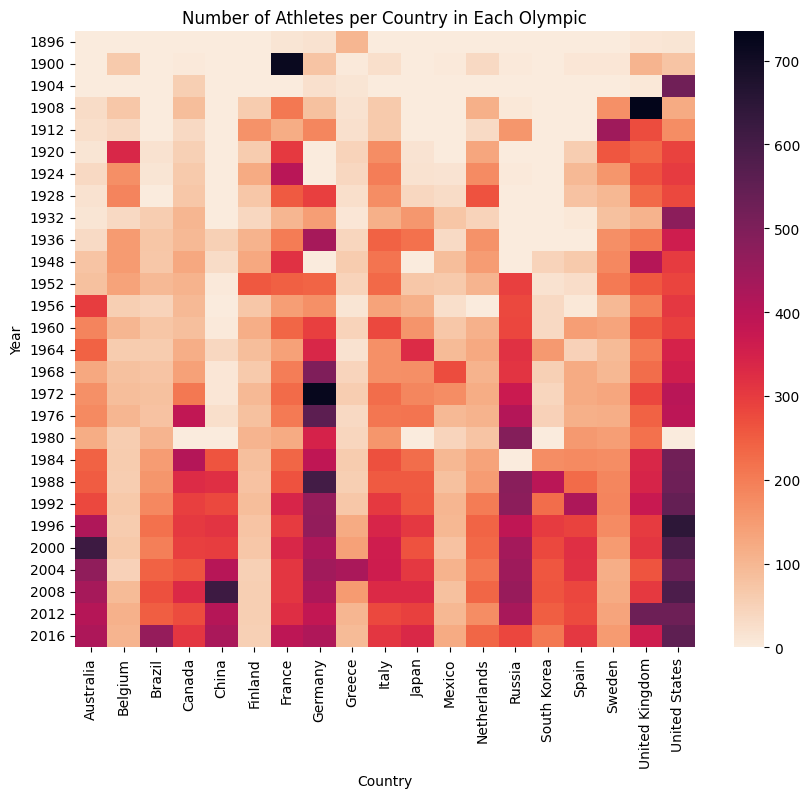

In [46]:
#lets make a data frame with the number of athletes each country had in each olympics
athletes_count = df_athletes.groupby(['region', 'Year'])['Name'].nunique().to_frame()
athletes_count = athletes_count.reset_index()
#lets cut it to only the countries that hosted the olympics
athletes_count = athletes_count[athletes_count['region'].isin(df_host_countries.index)]
athletes_count = athletes_count.pivot(index='Year', columns='region', values='Name')
athletes_count = athletes_count.fillna(0)
#lets make hit map
plt.figure(figsize=(10, 8))
sns.heatmap(athletes_count, cmap='rocket_r')
plt.title('Number of Athletes per Country in Each Olympic')
plt.xlabel('Country')
plt.ylabel('Year')
plt.xticks(rotation=90)

plt.show()
